### TWEET EMOTION RECOGNITION: NLP WITH TENSORFLOW
---

### Libraries

In [1]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

/home/fernandofincatti/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions

In [2]:
from src.functions.show import show_history, show_confusion_matrix
from src.functions.tweet import get_tweet, get_sequences, label_to_number

### Import data

In [3]:
dataset = nlp.load_dataset("emotion") #install data

Using custom data configuration default


In [4]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

### Split dataset

In [5]:
train = dataset["train"]
val = dataset["validation"]
test = dataset["test"]

In [6]:
print("Number of examples in train: {0}".format(len(train)))
print("Number of examples in validation: {0}".format(len(val)))
print("Number of examples in test: {0}".format(len(test)))

Number of examples in train: 16000
Number of examples in validation: 2000
Number of examples in test: 2000


###

### Tweets

In [7]:
tweets, labels = get_tweet(train)
print("Tweet: {0}\nLabel: {1}".format(tweets[0], labels[0]))

Tweet: i didnt feel humiliated
Label: sadness


### Tokenizer


In [8]:
# uses the tokenizer for the most common 10.000 words
# if an word isn't present on the most common, the corresponding token is <UNK>
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(tweets)

In [9]:
example_token = tokenizer.texts_to_sequences([tweets[0]])
print("Tweet: {0}\nToken: {1}".format(tweets[0], example_token))

Tweet: i didnt feel humiliated
Token: [[2, 139, 3, 679]]


### Padding and truncating sequences

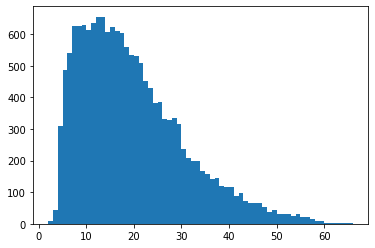

In [10]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=(len(set(lengths))))
plt.show()

In [11]:
train_seq_padded = get_sequences(tokenizer, tweets, maxlen=50)

In [12]:
train_seq_padded[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Preparing the labels

In [13]:
classes = set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

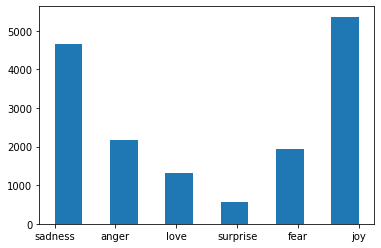

In [14]:
plt.hist(labels, bins=11)
plt.show()

In [15]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_classes = dict((v,k) for k, v in class_to_index.items())

In [16]:
class_to_index

{'surprise': 0, 'fear': 1, 'joy': 2, 'sadness': 3, 'love': 4, 'anger': 5}

In [17]:
index_to_classes

{0: 'surprise', 1: 'fear', 2: 'joy', 3: 'sadness', 4: 'love', 5: 'anger'}

In [18]:
train_labels = label_to_number(labels, class_to_index)

### Creating the model

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

2022-08-08 18:24:06.957717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 18:24:06.979764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 18:24:06.979897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 18:24:06.980287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


### Training model

In [21]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = label_to_number(val_labels, class_to_index)

In [22]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [23]:
h = model.fit(
    train_seq_padded, 
    train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)
    ]
)

Epoch 1/20


2022-08-08 18:24:11.256113: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302


500/500 [==============================] - 7s 8ms/step - loss: 1.3444 - accuracy: 0.4731 - val_loss: 0.9132 - val_accuracy: 0.6560
Epoch 2/20
500/500 [==============================] - 3s 6ms/step - loss: 0.6766 - accuracy: 0.7466 - val_loss: 0.6289 - val_accuracy: 0.7780
Epoch 3/20
500/500 [==============================] - 3s 6ms/step - loss: 0.3871 - accuracy: 0.8674 - val_loss: 0.4695 - val_accuracy: 0.8455
Epoch 4/20
500/500 [==============================] - 3s 6ms/step - loss: 0.2366 - accuracy: 0.9199 - val_loss: 0.4374 - val_accuracy: 0.8480
Epoch 5/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1667 - accuracy: 0.9471 - val_loss: 0.4113 - val_accuracy: 0.8710
Epoch 6/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1246 - accuracy: 0.9593 - val_loss: 0.4102 - val_accuracy: 0.8810
Epoch 7/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1046 - accuracy: 0.9681 - val_loss: 0.3807 - val_accuracy: 0.8905
Epoch 8/20
500/50

### Evaluating the model

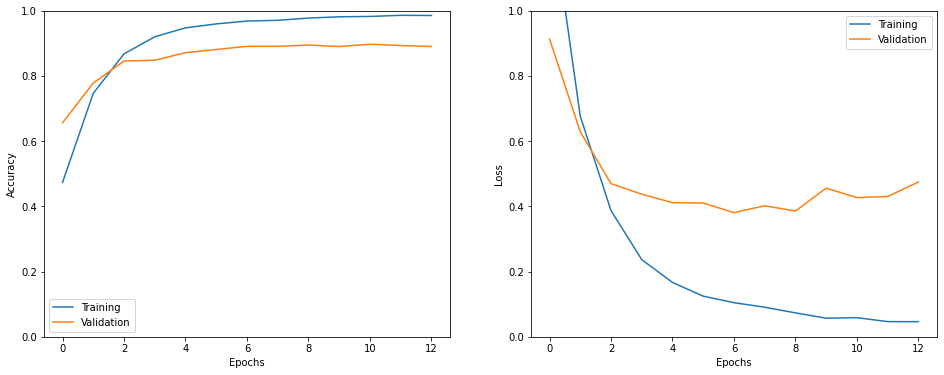

In [24]:
show_history(h)

In [25]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = label_to_number(test_labels, class_to_index)

In [26]:
evaluate = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 3ms/step - loss: 0.4751 - accuracy: 0.8840


63/63 [==============================] - 1s 2ms/step


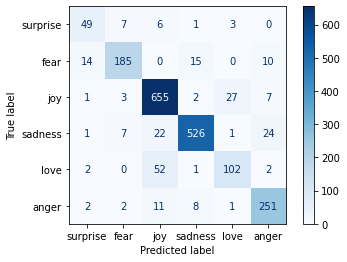

In [27]:
preds = model.predict(test_seq)
classes_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(test_labels, classes_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [29]:
i = random.randint(0, len(test_labels)-1)
print("Sentence: {0}".format(test_tweets[i]))
print("Emotion: {0}".format(index_to_classes[test_labels[i]]))
p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_classes[np.argmax(p).astype("uint8")]
print("Predicted emotion: {0}".format(pred_class))

Sentence: i bought this doraemon backpack from a charity store i had every intention of putting it in my etsy store but i feel like its too cute to sell
Emotion: joy
1/1 [==============================] - 0s 14ms/step
Predicted emotion: joy
